# Unet Satcen Finetuning

Fine tune the Unet model trained on the Airbus dataset using the Satcen dataset.

## Split the Dataset

Load and split the *full* Satcen dataset into **60-20-20 stratified** train, validation and test sets. Save the files in the *satcen_dataset/full/splits/x* (where x: {'train', 'validation', 'test'}) folders.

In [59]:
import os
import pathlib
from PIL import Image, ImageDraw as Drawer
import matplotlib.pyplot as plt
import numpy as np
import ijson
import json
from sklearn.model_selection import train_test_split
import shutil
from fastai.vision.all import *
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

# path to satcen dataset
satcen_path = pathlib.Path('../satcen_dataset/full').resolve()

# path to original satcen dataset
satcen_path_original = pathlib.Path('../satcen_dataset/original').resolve()

### Load the Data

Load all Satcen images with their annotations (bounding boxes) and convert the annotations to binary labels for future use.

In [2]:
# load the full Satcen dataset
satcen = os.listdir(satcen_path/'pictures')

# load the labels (bounding boxes)
labels_file = open(satcen_path/'labels.json')
labels_json = json.load(labels_file)

# conver the bounding boxes into binary labels 0/1
y = np.array([])
for img in satcen:

    bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']
    y = np.append(y, 1 if len(bounding_boxes) > 0 else 0)

# print info about entire dataset
print(f'Total number of Satcen images: {len(satcen)}')
print(f'Total number of labels (annotations): {len(labels_json)}')
print(f'Number of positive observations: {np.sum(y==1)} ({100 * np.sum(y==1) / len(y):.2f}%)')
print(f'Number of negative observations: {np.sum(y==0)} ({100 * np.sum(y==0) / len(y):.2f}%)')

Total number of Satcen images: 9420
Total number of labels (annotations): 9420
Number of positive observations: 1525 (16.19%)
Number of negative observations: 7895 (83.81%)


### Split the Data

Perform a stratified split over the data into train, validation and test sets and save the images (**DONE ONCE**) in the corresponding folders.

In [3]:
# # make the splits
# train_images, test_valid_images, y_train, y_test_valid = train_test_split(satcen, y, test_size=0.4, stratify=y, random_state=27)
# valid_images, test_images, y_valid, y_test = train_test_split(test_valid_images, y_test_valid, test_size=0.5, stratify=y_test_valid, random_state=27)

# # print stats about the splits
# print('Train dataset')
# print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
# print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

# print('\nValidation dataset')
# print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
# print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

# print('\nTest dataset')
# print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
# print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

# # copy the training images
# for img in train_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/train/images'/img
#     shutil.copy(src, dst)

# # copy the validation images
# for img in valid_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/validation/images'/img
#     shutil.copy(src, dst)

# # copy the test images
# for img in test_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/test/images'/img
#     shutil.copy(src, dst)

print(f'\nSize of train folder: {len(os.listdir(satcen_path/"splits/train/images"))}')
print(f'Size of validation folder: {len(os.listdir(satcen_path/"splits/validation/images"))}')
print(f'Size of test folder: {len(os.listdir(satcen_path/"splits/test/images"))}')


Size of train folder: 5652
Size of validation folder: 1884
Size of test folder: 1884


### Load the Split Data

Load the train, validation and test data from their corresponding folders. 
Compute the binary labels for each set.

In [4]:
# load the data
train_images = os.listdir(satcen_path/'splits/train/images')
valid_images = os.listdir(satcen_path/'splits/validation/images')
test_images = os.listdir(satcen_path/'splits/test/images')

# compute binary labels for each set
y_train = np.array([y[satcen.index(img)] for img in train_images])
y_valid = np.array([y[satcen.index(img)] for img in valid_images])
y_test = np.array([y[satcen.index(img)] for img in test_images])

# print stats about the splits
print('Train dataset')
print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

print('\nValidation dataset')
print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

print('\nTest dataset')
print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

Train dataset
Size: 5652 (60.00%)
Positive observations: 915 (16.19%)
Negative observations: 4737 (83.81%)

Validation dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)

Test dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)


## Generate Ground Truth Labels

Compute ground truth for images in the Satcen dataset based on the given bounding boxes.
Ground truth labels should be saved as *.png* files in the *satcen_dataset/ground_truth_masks* folder. Files should have _L at the end of the filename.

In each ground truth image:
- 0 pixel value represents background pixel
- 1 pixel value represents ship pixel

In [5]:
# compute segmentation mask of a Satcen image based on its bounding box
# @param img_name - filename of the image for which to compute ground truth
# @param bounding_boxes - list of bounding boxes for that image
# @param save - whether or not to save the mask
# @param path - where to save the mask
# @return mask - PIL image representing the mask of the given image
def get_image_mask_satcen(img_name, bounding_boxes, path, save = False):
    
    # create the skeleton of the segmentation mask
    # size is constant for satcen dataset, 256 x 256
    mask = Image.fromarray(np.zeros((256, 256)), 'P')

    # get a drawer object
    draw = Drawer.Draw(mask)

    # loop through the bounding boxes
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw the bounding box on the image
        draw.polygon(coords, fill=1)

    if save:
        mask.save(path/f'{img_name[:-4]}_L.png')

    return mask

# function that generates and saves masks for Satcen images
# @param path - where to save the masks
def save_all_satcen_masks(path):

    # delete all the files in the target directory
    for f in os.listdir(path):
        os.remove(path/f)

    # loop through all satcen images
    for img in satcen:

        # get the corresponding list of bounding boxes
        bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']

        # generate and save mask
        get_image_mask_satcen(img, bounding_boxes, path, save=True)

# save_all_satcen_masks(satcen_path/'ground_truth_masks')

### Show a Few Examples

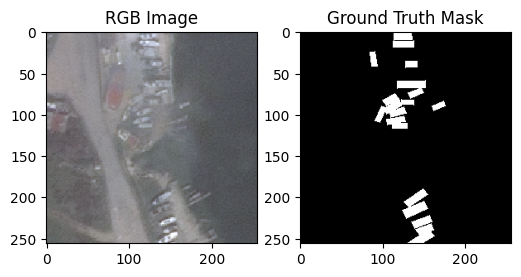

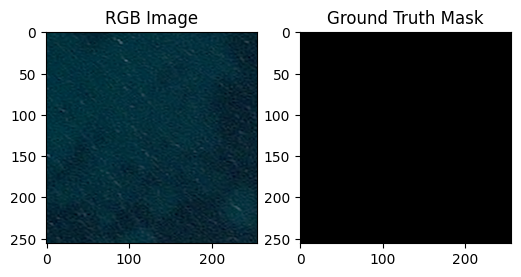

In [6]:
# get one image that contains ships and one that does not
ship_img = satcen[np.where(y==1)[0][0]]
no_ship_img = satcen[np.where(y==0)[0][1]]

# show images and ground truth
fig = plt.subplots(1, 2, figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow(Image.open(satcen_path/'pictures'/ship_img))
plt.subplot(1, 2, 2)
plt.title('Ground Truth Mask')
plt.imshow(PILMask.create(satcen_path/'ground_truth_masks'/f'{ship_img[:-4]}_L.png'), cmap='gray')
plt.show()

fig = plt.subplots(1, 2, figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow(Image.open(satcen_path/'pictures'/no_ship_img))
plt.subplot(1, 2, 2)
plt.title('Ground Truth Mask')
plt.imshow(PILMask.create(satcen_path/'ground_truth_masks'/f'{no_ship_img[:-4]}_L.png'), cmap='gray')
plt.show()

## Fine Tuning

### Construct the Model

Construct the model in the same way as the original one trained on the Airbus dataset. Load the weights of the Airbus model.

Save the model as *unet_satcen_finetuned.pth* in the *ship_detection/models* folder.

DynamicUnet (Input shape: 4 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 192 x 64 x 64   
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     4 x 192 x 32 x 32   
MaxPool2d                                   

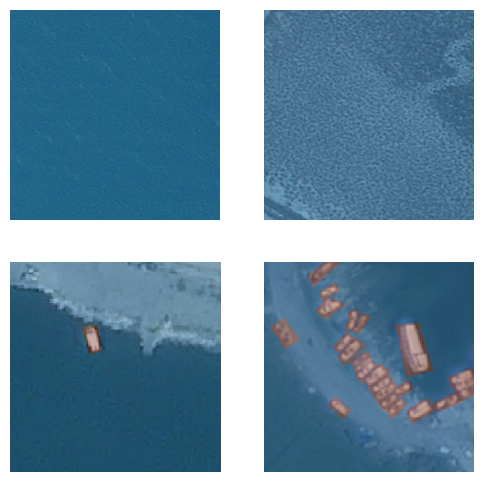

In [7]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'ground_truth_masks'/f'{fn.stem}_L.png'

# create a datablock
dblock = DataBlock( 
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation')
)

# load the data in the datablock
dataset = dblock.datasets(satcen_path/'splits/')
dls = dblock.dataloaders(satcen_path/'splits/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=12)

# create the learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4,
    metrics=[JaccardCoeff()]
)

# load the model
unet.load('unet_googlenet')

# print model architecture
unet.summary()

### Train the Model

Train using the same approach as the original model, then save the model.

In [8]:
# # train the model
# unet.fine_tune(4, freeze_epochs=3)

# # save the model
# print('Saving model...')
# unet.save('unet_satcen_finetuned')
# print('Saved model')

## Testing

Test the fine-tuned model on the **validation set** (*satcen_dataset/full/splits/validation/images*). 

### Define Activation and Decoding Functions

The fast.ai implementation of FocalLoss does not come with built-in activation and decoding functions. The output of U-net consists of two values for each pixel, one corresponding to the ship class and the other to the background class. 

Implement and attach the functions to the FocalLoss loss function as follows:
- **activation:** apply *softmax* pixel-wise on the two values
- **decodes:** take the pixel-wise *argmax* of the two values

In [8]:
# define activation function
def focalLossActivation(self, x:Tensor) -> Tensor:
    return F.softmax(x, dim=1)

# define loss function
def focalLossDecodes(self, x:Tensor) -> Tensor:
    return x.argmax(dim=1)

# attach the functions to focal loss
FocalLoss.activation = focalLossActivation
FocalLoss.decodes = focalLossDecodes

### Load the model

Load the fine-tuned U-net model.

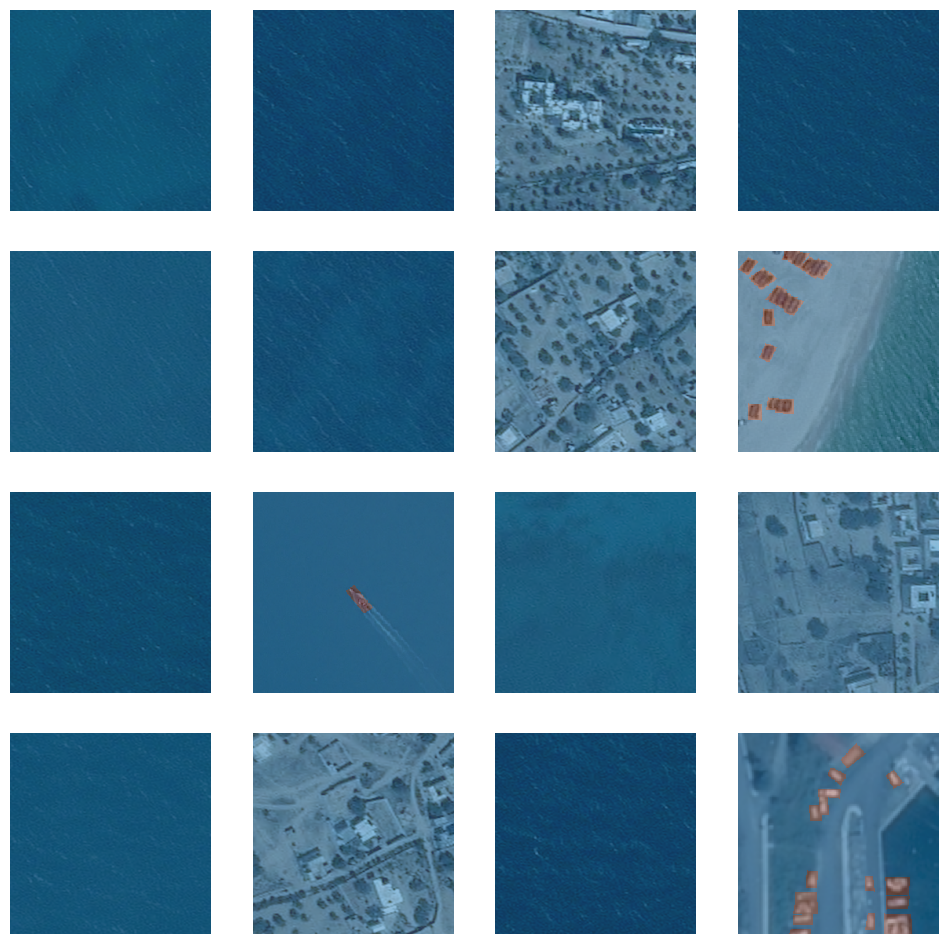

In [9]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'ground_truth_masks'/f'{fn.stem}_L.png'

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation')
)

# load the data in the datablock
torch.cuda.init()
dataset = dblock.datasets(satcen_path/'splits/')
dls = dblock.dataloaders(satcen_path/'splits/', bs=16, device=torch.device('cuda'))

dls.show_batch(max_n=16)

# create the learner
unet_finetuned = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet_finetuned.load('unet_satcen_finetuned')

### Generate the Predictions

Perform inference on the validation set.

The *get_preds* function returns a tuple representing **(prediction, target)**. The prediction has shape 1884 x 2 x 256 x 256, as there are 1884 observations in the validation set and the outputs has not been decoded. The raw outputs have been passed through the *softmax* activation function.

In [10]:
torch.cuda.empty_cache()
preds, targets = unet_finetuned.get_preds()

### Decode the Predictions (argmax decoding)

U-net outputs two values for each pixel, one corresponding to the ship class and the other to the background class. To decode the output, choose the greater value.

In [11]:
decoded_preds = preds.argmax(dim=1)
print(decoded_preds.shape)

torch.Size([1884, 256, 256])


### Compute Metrics

If the decoded output contains at least 1 ship pixel (pixel value = 1), it is classified as a positive observation. Otherwise, it is a negative observation.

With this approach, calculate: *TP*, *FP*, *TN*, *FN*, *precision*, *TPR* *(recall)*, *FPR*

In [12]:
tp, fp, tn, fn = 0, 0, 0, 0

# loop through the predictions
for i, pred_image in enumerate(decoded_preds):
    
    # determine the label
    y_pred = 1 if torch.any(pred_image==1) else 0

    # get the actual label
    y_true = y_valid[i]

    # determine the type of prediction
    if y_pred == 1:
        if y_true == 1:
            tp += 1
        else:
            fp += 1
    else:
        if y_true == 0:
            tn += 1
        else:
            fn += 1

# calculate condition positives and condition negatives
condition_pos = np.sum(y_valid==1)
condition_neg = np.sum(y_valid==0)

# calculate precision, recall, FPR
precision = tp / (tp + fp)
recall = tp / condition_pos
fpr = fp / condition_neg

# report metrics
print('Results using argmax approach')
print(f'TP: {tp}')
print(f'FP: {fp}')
print(f'TN: {tn}')
print(f'FN: {fn}')
print()
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'FPR: {fpr}')

Results using argmax approach
TP: 295
FP: 27
TN: 1552
FN: 10

Precision: 0.9161490683229814
Recall: 0.9672131147540983
FPR: 0.017099430018999367


### ROC and PR Curves

For each pixel in the input image, we get 2 probabilities (that sum up to 1), after the raw output of U-net has been passed through the softmax activation function:
- probability that the pixel is *background*
- probability that the pixel is *ship*

Threshold the probability that the pixel is a ship pixel and plot the ROC and PR curves.

<span style="font-weight: bold; color:red">Question: if the ship probability is less than 0.5, the background probability will be greater than the ship probability. Why not choose background probability if it is greater?</span>


AUC-ROC: 0.9973463179642647


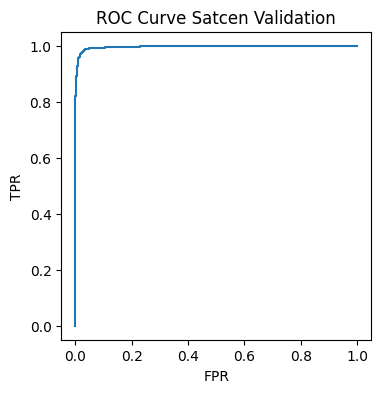

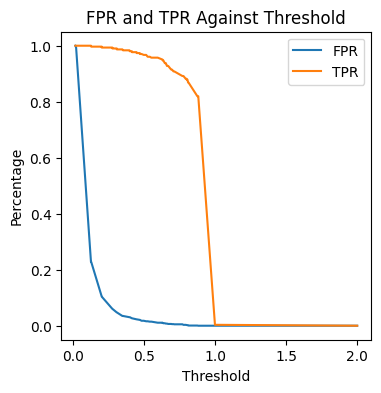

AUC-PR: 0.9895178038216742


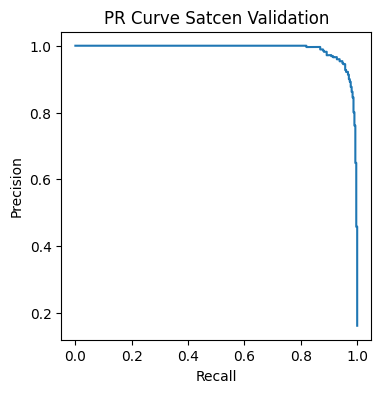

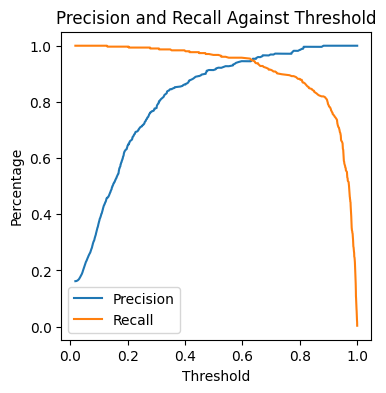

In [65]:
# compute and save decision scores
z = [torch.max(probs) for probs in preds[:, 1]]

# define figure size for all plots
figsize = (4, 4)

# ROC
fprs, tprs, thresholds = roc_curve(y_valid, z)
print(f'AUC-ROC: {auc(fprs, tprs)}')
plt.figure(figsize=figsize)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Satcen Validation')
plt.show()

plt.figure(figsize=figsize)
plt.plot(thresholds, fprs, thresholds, tprs)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend(['FPR', 'TPR'])
plt.title('FPR and TPR Against Threshold')
plt.show()

# PR
precisions, recalls, thresholds = precision_recall_curve(y_valid, z)
print(f'AUC-PR: {auc(recalls, precisions)}')
plt.figure(figsize=figsize)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Satcen Validation')
plt.show()

thresholds = np.append(thresholds, math.inf)
plt.figure(figsize=figsize)
plt.plot(thresholds, precisions, thresholds, recalls)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Precision and Recall Against Threshold')
plt.legend(['Precision', 'Recall'])
plt.show()